# Metaheuristic with Original Inputs:



In [1]:
#  Imports
from src.parsers import HMParser
from src.resources import BinaryResource, Generator, Load, Storage, Vehicle
from src.scenes import HMProblemScene
import build_data
from build_data import ext_pyomo_vals
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

from help_methods import *
# Ignore the warnings (only demonstration purposes!)
import warnings
warnings.filterwarnings("ignore")

### Defining set up variables, important to get the data from mysql db.

In [2]:
# Set up variables 

_specific_date='2019-11-06' # -> Change date
_time_step = 60 # -> Change time step
_update_forecast = False # -> True to have forecast updat in the operation
_save_plots = True # -> True to save the plots

#Comentarios sobre performance de dias
#Dia 6 corre rapido
#ao fim do dia 13 as previsões sao maiores do q o consumo real
#dia 16/17 é um exemplo de uma pessima previsão

# Method 1 - Forecast Data:

In this method, it is used the data from mysql forecast databases as input for load and generators.

In [3]:
# Data parsing
method_obj_1 = build_data.Data(_file_path='data/EC_V4_new_UC1.xlsx', ec_id=1) 

In [4]:
method_obj_1.data.storage.keys()

dict_keys(['p_charge_limit', 'p_discharge_limit', 'charge_price', 'discharge_price', 'internal_bus_location', 'battery_type', 'owner', 'manager', 'type_contract', 'energy_capacity', 'energy_min_percentage', 'charge_efficiency', 'discharge_efficiency', 'initial_state', 'p_charge_max', 'p_discharge_max'])

In [5]:
method1_folder = "./input_data/UC1/method1"

# Define generators
gens1 = Generator(name='gens',
                 value=np.zeros(method_obj_1.data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(method_obj_1.data.generator['p_forecast'].shape),
                 upper_bound=method_obj_1.data.generator['p_forecast'],
                 cost=method_obj_1.data.generator['cost_parameter_b'],
                 cost_nde=method_obj_1.data.generator['cost_nde'],
                 is_renewable=method_obj_1.data.generator['type_generator'])

method_obj_1.get_data_from_db(specific_date=_specific_date, table="generators_forecast", end = 24*60//_time_step, experiment_id = 17, time_step=_time_step, folder=method1_folder, save=True)


# Define loads
loads1 = Load(name='loads',
             value=method_obj_1.data.load['p_forecast'],
             lower_bound=np.zeros(method_obj_1.data.load['p_forecast'].shape),
             upper_bound=method_obj_1.data.load['p_forecast'],
             cost=np.ones(method_obj_1.data.load['p_forecast'].shape),
             cost_cut=method_obj_1.data.load['cost_cut'],
             cost_reduce=method_obj_1.data.load['cost_reduce'],
             cost_ens=method_obj_1.data.load['cost_ens'])


method_obj_1.get_data_from_db(specific_date=_specific_date, table="loads_forecast", end = 24*60//_time_step, experiment_id = 23, time_step=_time_step, folder=method1_folder, save=True)

# Define storage
stor1 = Storage(name='stor',
               value=np.zeros(method_obj_1.data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(method_obj_1.data.storage['p_charge_limit'].shape),
               upper_bound=(method_obj_1.data.storage['energy_capacity'] *
                            np.ones(method_obj_1.data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(method_obj_1.data.storage['p_charge_limit'].shape),
               cost_discharge=method_obj_1.data.storage['discharge_price'],
               cost_charge=method_obj_1.data.storage['charge_price'],
               capacity_max=method_obj_1.data.storage['energy_capacity'],
               capacity_min=method_obj_1.data.storage['energy_min_percentage'],
               initial_charge=method_obj_1.data.storage['initial_state'],
               discharge_efficiency=method_obj_1.data.storage['discharge_efficiency'],
               discharge_max=method_obj_1.data.storage['p_discharge_limit'],
               charge_efficiency=method_obj_1.data.storage['charge_efficiency'],
               charge_max=method_obj_1.data.storage['p_charge_limit'],
               #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
               #@TODO Coloquei array tamanho 4 no capital cost pois há 4 css
               capital_cost=np.array([0.05250, 0.10500, 0.01575, 0.01575]))
stor1.to_json(path=method1_folder)

# Define vehicle to grid
v2g1 = Vehicle(name='evs',
              value=np.zeros(method_obj_1.data.vehicle['schedule_charge'].shape),
              lower_bound=(method_obj_1.data.vehicle['e_capacity_max'] * method_obj_1.data.vehicle['min_technical_soc'] *
                           np.ones(method_obj_1.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(method_obj_1.data.vehicle['e_capacity_max'] * np.ones(method_obj_1.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(method_obj_1.data.vehicle['schedule_charge'].shape),
              cost_discharge=method_obj_1.data.vehicle['discharge_price'][:, 0],
              cost_charge=method_obj_1.data.vehicle['charge_price'][:, 0],
              capacity_max=method_obj_1.data.vehicle['e_capacity_max'],
              initial_charge=np.ones(method_obj_1.data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=method_obj_1.data.vehicle['min_technical_soc'],
              discharge_efficiency=method_obj_1.data.vehicle['discharge_efficiency'],
              charge_efficiency=method_obj_1.data.vehicle['charge_efficiency'],
              #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
              #@TODO Coloquei array tamanho 7 no capital cost pois há 7 carros
              capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063, 0.063, 0.063]), 
              schedule_discharge=method_obj_1.data.vehicle['schedule_discharge'],
              schedule_charge=method_obj_1.data.vehicle['schedule_charge'])
v2g1.to_json(path=method1_folder)

# Define imports and exports
pimp1 = BinaryResource(name='pImp',
                      value=np.zeros(method_obj_1.data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_1.data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_1.data.peers['import_contracted_p_max'][0, :],
                      cost=method_obj_1.data.peers['buy_price'][0, :],
                      is_active=np.zeros(method_obj_1.data.peers['import_contracted_p_max'][0, :].shape))
pimp1.to_json(path=method1_folder)

pexp1 = BinaryResource(name='pExp',
                      value=np.zeros(method_obj_1.data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_1.data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_1.data.peers['export_contracted_p_max'][0, :],
                      cost=method_obj_1.data.peers['sell_price'][0, :],
                      is_active=np.zeros(method_obj_1.data.peers['export_contracted_p_max'][0, :].shape))
pexp1.to_json(path=method1_folder)

# Establish the components
ec_components = {'gen': gens1,
                 'loads': loads1,
                 'stor': stor1,
                 'evs': v2g1,
                 'pimp': pimp1,
                 'pexp': pexp1}

ec_components

{'gen': gens,
 'loads': loads,
 'stor': stor,
 'evs': evs,
 'pimp': pImp,
 'pexp': pExp}

In [6]:
# Create the scene

scene = HMProblemScene(name='EC1', data=ec_components, hm_parser=method_obj_1.data, pop_size=20,
                       n_iter=10, iter_tolerance=1000)
scene.initialize()
scene.run()

100%|██████████| 10/10 [00:00<00:00, 20.83it/s]


In [7]:
scene.to_json(path="./results/UC1/method_1", filename="scene1_results")

In [8]:
scene.export_profile_to_excel(scene.current_best['genActPower'], scene.current_best['storDchActPower'],
                              scene.current_best['v2gDchActPower'], scene.current_best['loadRedActPower'],
                              scene.current_best['loadCutActPower'], scene.current_best['loadENS'],
                              scene.current_best['pImp'], scene.current_best['genExcActPower'],
                              scene.current_best['storChActPower'], scene.current_best['v2gChActPower'],
                              loads1.value,
                              name="profile_data_1.xlsx", path="results/method_1"
                              )

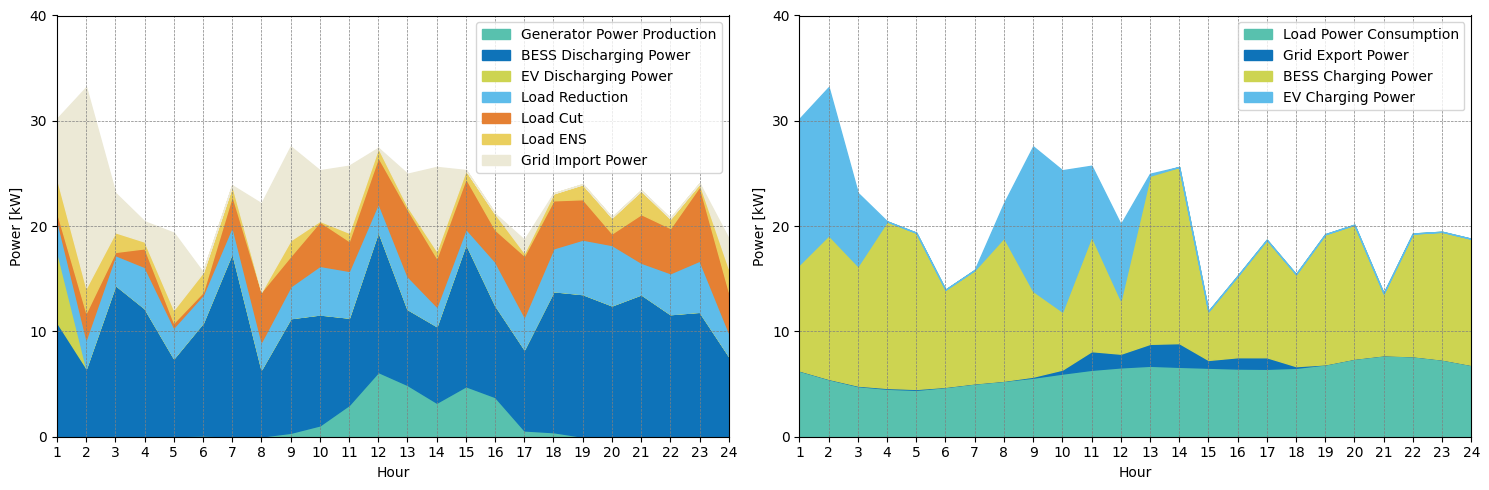

In [9]:
scene.plot(scene.current_best['genActPower'], scene.current_best['storDchActPower'],
                              scene.current_best['v2gDchActPower'], scene.current_best['loadRedActPower'],
                              scene.current_best['loadCutActPower'], scene.current_best['loadENS'],
                              scene.current_best['pImp'], scene.current_best['genExcActPower'],
                              scene.current_best['storChActPower'], scene.current_best['v2gChActPower'],
                              loads1.value, save=True,
                              name="profile_data_1", path="plots/UC1/method_1", graph_max=40, graph_step=10)

In [10]:
#scene.components['evs'].capital_cost
v2g1.cost_discharge

array([0.05, 0.06, 0.05, 0.05, 0.06, 0.06, 0.06], dtype=object)

In [11]:
# Sum matrices along the columns

scene.algo.population_fitness

[330.40748922184264,
 348.54232449748554,
 356.62065389978807,
 370.2941756171474,
 389.85586513019575,
 346.4884548101818,
 364.1976961754207,
 340.1902008123793,
 337.747465819305,
 341.1511156707376,
 340.8285115088825,
 367.74718321703705,
 347.9623265232646,
 387.04788111001716,
 360.5344512268608,
 337.78862315062264,
 371.7256953422969,
 371.44268568627615,
 358.3793642931022,
 351.3599682373708]

In [12]:
 # Check the population

scene.algo.population

array([[1.20636335e-02, 1.00069290e-02, 4.48667216e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.82715511e-03, 3.61612830e-03, 6.68947164e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.40835791e-02, 0.00000000e+00, 8.09556141e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [6.18640498e-03, 7.91022062e-03, 7.68001249e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.36727387e-02, 3.50155945e-03, 1.49021275e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [7.74736361e-03, 9.13214913e-03, 5.00488993e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

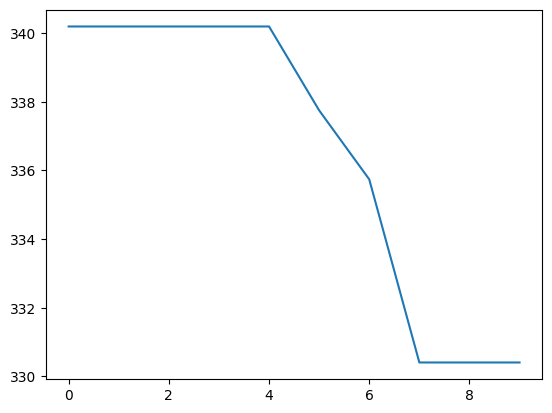

In [13]:
plt.plot(scene.algo.population_history_fitness)

In [14]:
scene.algo.population_history_fitness

[340.1902008123793,
 340.1902008123793,
 340.1902008123793,
 340.1902008123793,
 340.1902008123793,
 337.747465819305,
 335.73879780112196,
 330.40748922184264,
 330.40748922184264,
 330.40748922184264]

In [15]:
scene.algo.population_fitness

[330.40748922184264,
 348.54232449748554,
 356.62065389978807,
 370.2941756171474,
 389.85586513019575,
 346.4884548101818,
 364.1976961754207,
 340.1902008123793,
 337.747465819305,
 341.1511156707376,
 340.8285115088825,
 367.74718321703705,
 347.9623265232646,
 387.04788111001716,
 360.5344512268608,
 337.78862315062264,
 371.7256953422969,
 371.44268568627615,
 358.3793642931022,
 351.3599682373708]

In [16]:
scene.current_best_fitness

330.6154549794445

# Method 2 - Real Data

In [17]:
# Data parsing
method_obj_2 = build_data.Data(_file_path='data/EC_V4_new_UC1.xlsx', ec_id=1) 

In [18]:
method_obj_2.data.storage.keys()

dict_keys(['p_charge_limit', 'p_discharge_limit', 'charge_price', 'discharge_price', 'internal_bus_location', 'battery_type', 'owner', 'manager', 'type_contract', 'energy_capacity', 'energy_min_percentage', 'charge_efficiency', 'discharge_efficiency', 'initial_state', 'p_charge_max', 'p_discharge_max'])

In [19]:
method2_folder = "./input_data/UC1/method2"

# Define generators
gens2 = Generator(name='gens2',
                 value=np.zeros(method_obj_2.data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(method_obj_2.data.generator['p_forecast'].shape),
                 upper_bound=method_obj_2.data.generator['p_forecast'],
                 cost=method_obj_2.data.generator['cost_parameter_b'],
                 cost_nde=method_obj_2.data.generator['cost_nde'],
                 is_renewable=method_obj_2.data.generator['type_generator'])

method_obj_2.get_data_from_db(specific_date=_specific_date, table="generators", end = 24*60//_time_step, 
                             time_step=_time_step, folder=method2_folder, save=True)


# Define loads
loads2 = Load(name='loads2',
             value=method_obj_2.data.load['p_forecast'],
             lower_bound=np.zeros(method_obj_2.data.load['p_forecast'].shape),
             upper_bound=method_obj_2.data.load['p_forecast'],
             cost=np.ones(method_obj_2.data.load['p_forecast'].shape),
             cost_cut=method_obj_2.data.load['cost_cut'],
             cost_reduce=method_obj_2.data.load['cost_reduce'],
             cost_ens=method_obj_2.data.load['cost_ens'])


method_obj_2.get_data_from_db(specific_date=_specific_date, table="loads", end = 24*60//_time_step, 
                            time_step=_time_step, folder=method2_folder, save=True)

# Define storage
stor2 = Storage(name='stor2',
               value=np.zeros(method_obj_2.data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(method_obj_2.data.storage['p_charge_limit'].shape),
               upper_bound=(method_obj_2.data.storage['energy_capacity'] *
                            np.ones(method_obj_2.data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(method_obj_2.data.storage['p_charge_limit'].shape),
               cost_discharge=method_obj_2.data.storage['discharge_price'],
               cost_charge=method_obj_2.data.storage['charge_price'],
               capacity_max=method_obj_2.data.storage['energy_capacity'],
               capacity_min=method_obj_2.data.storage['energy_min_percentage'],
               initial_charge=method_obj_2.data.storage['initial_state'],
               discharge_efficiency=method_obj_2.data.storage['discharge_efficiency'],
               discharge_max=method_obj_2.data.storage['p_discharge_limit'],
               charge_efficiency=method_obj_2.data.storage['charge_efficiency'],
               charge_max=method_obj_2.data.storage['p_charge_limit'],
               #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
               #@TODO Coloquei array tamanho 4 no capital cost pois há 4 css
               capital_cost=np.array([0.05250, 0.10500, 0.01575, 0.01575]))
stor2.to_json(path=method2_folder)

# Define vehicle to grid
v2g2 = Vehicle(name='evs2',
              value=np.zeros(method_obj_2.data.vehicle['schedule_charge'].shape),
              lower_bound=(method_obj_2.data.vehicle['e_capacity_max'] * method_obj_2.data.vehicle['min_technical_soc'] *
                           np.ones(method_obj_2.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(method_obj_2.data.vehicle['e_capacity_max'] * np.ones(method_obj_2.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(method_obj_2.data.vehicle['schedule_charge'].shape),
              cost_discharge=method_obj_2.data.vehicle['discharge_price'][:, 0],
              cost_charge=method_obj_2.data.vehicle['charge_price'][:, 0],
              capacity_max=method_obj_2.data.vehicle['e_capacity_max'],
              initial_charge=np.ones(method_obj_2.data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=method_obj_2.data.vehicle['min_technical_soc'],
              discharge_efficiency=method_obj_2.data.vehicle['discharge_efficiency'],
              charge_efficiency=method_obj_2.data.vehicle['charge_efficiency'],
              #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
              #@TODO Coloquei array tamanho 7 no capital cost pois há 7 carros
              capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063, 0.063, 0.063]), 
              schedule_discharge=method_obj_2.data.vehicle['schedule_discharge'],
              schedule_charge=method_obj_2.data.vehicle['schedule_charge'])
v2g2.to_json(path=method2_folder)

# Define imports and exports
pimp2 = BinaryResource(name='pImp2',
                      value=np.zeros(method_obj_2.data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_2.data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_2.data.peers['import_contracted_p_max'][0, :],
                      cost=method_obj_2.data.peers['buy_price'][0, :],
                      is_active=np.zeros(method_obj_2.data.peers['import_contracted_p_max'][0, :].shape))
pimp2.to_json(path=method2_folder)

pexp2 = BinaryResource(name='pExp2',
                      value=np.zeros(method_obj_2.data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_2.data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_2.data.peers['export_contracted_p_max'][0, :],
                      cost=method_obj_2.data.peers['sell_price'][0, :],
                      is_active=np.zeros(method_obj_2.data.peers['export_contracted_p_max'][0, :].shape))
pexp2.to_json(path=method2_folder)

# Establish the components
ec_components = {'gen': gens2,
                 'loads': loads2,
                 'stor': stor2,
                 'evs': v2g2,
                 'pimp': pimp2,
                 'pexp': pexp2}

ec_components

{'gen': gens2,
 'loads': loads2,
 'stor': stor2,
 'evs': evs2,
 'pimp': pImp2,
 'pexp': pExp2}

In [20]:
# Create the scene

scene2 = HMProblemScene(name='EC2', data=ec_components, hm_parser=method_obj_2.data, pop_size=20,
                       n_iter=10, iter_tolerance=1000)
scene2.initialize()
scene2.run()

 40%|████      | 4/10 [00:00<00:00, 15.84it/s]

100%|██████████| 10/10 [00:00<00:00, 16.77it/s]


In [21]:
scene2.to_json(path="./results/UC1/method_2", filename="scene2_results")

In [22]:
scene2.current_best.keys()

dict_keys(['genActPower', 'genExcActPower', 'pImp', 'pExp', 'loadRedActPower', 'loadCutActPower', 'loadENS', 'storDchActPower', 'storChActPower', 'EminRelaxStor', 'storEnerState', 'v2gDchActPower', 'v2gChActPower', 'EminRelaxEV', 'v2gEnerState', 'genXo', 'loadXo', 'storDchXo', 'storChXo', 'v2gDchXo', 'v2gChXo'])

In [23]:
scene2.export_profile_to_excel(scene2.current_best['genActPower'], scene2.current_best['storDchActPower'],
                              scene2.current_best['v2gDchActPower'], scene2.current_best['loadRedActPower'],
                              scene2.current_best['loadCutActPower'], scene2.current_best['loadENS'],
                              scene2.current_best['pImp'], scene2.current_best['genExcActPower'],
                              scene2.current_best['storChActPower'], scene2.current_best['v2gChActPower'],
                              loads2.value,
                              name="profile_data_2.xlsx", path="results/method_2"
                              )

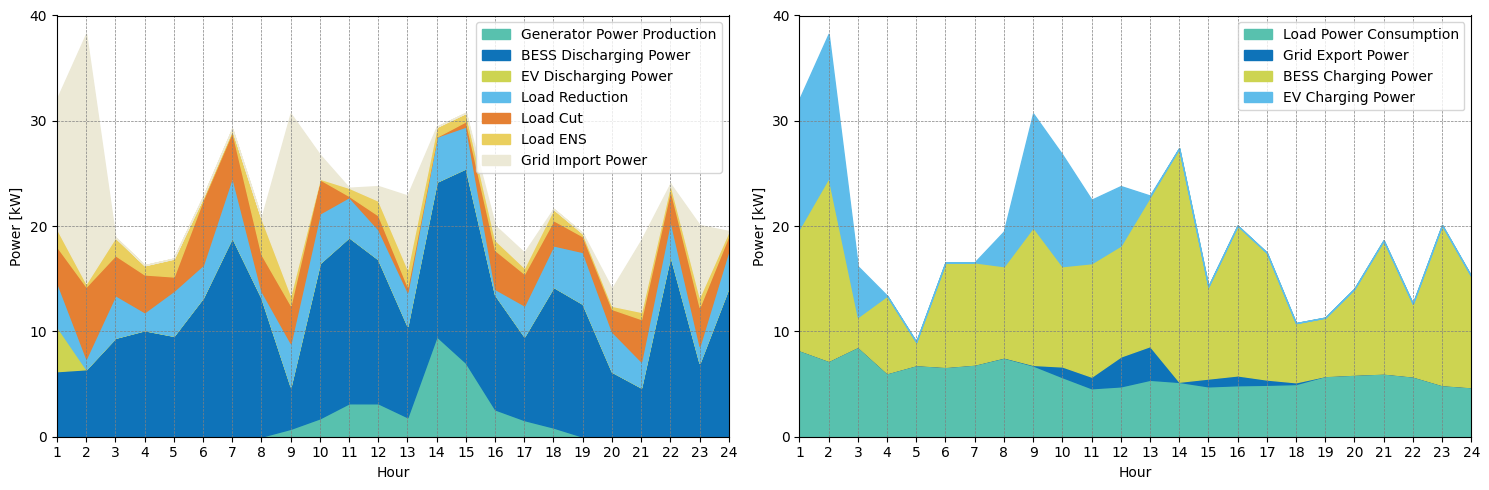

In [24]:
scene2.plot(scene2.current_best['genActPower'], scene2.current_best['storDchActPower'],
                              scene2.current_best['v2gDchActPower'], scene2.current_best['loadRedActPower'],
                              scene2.current_best['loadCutActPower'], scene2.current_best['loadENS'],
                              scene2.current_best['pImp'], scene2.current_best['genExcActPower'],
                              scene2.current_best['storChActPower'], scene2.current_best['v2gChActPower'],
                              loads2.value, save=True,
                              name="profile_data_2", path="plots/UC1/method_2", graph_max=40, graph_step=10)

In [25]:
#scene.components['evs'].capital_cost
v2g2.cost_discharge

array([0.05, 0.06, 0.05, 0.05, 0.06, 0.06, 0.06], dtype=object)

In [26]:
# Sum matrices along the columns

scene2.algo.population_fitness

[368.0894409517249,
 310.0544885196208,
 335.58233070419465,
 318.12623932064434,
 315.1496671651793,
 327.73977093838477,
 303.9627587413872,
 299.8238155412313,
 338.8039608779234,
 307.2186758704006,
 334.4424525799777,
 341.2838545218737,
 311.22616075589934,
 365.28983899142963,
 340.2224448087586,
 335.975775038453,
 335.6610702031585,
 340.6542552642148,
 324.3669825076602,
 359.7630513083657]

In [27]:
 # Check the population

scene2.algo.population

array([[9.68035350e-09, 2.61490806e-09, 6.20835721e-10, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 8.27875212e-09, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.33140452e-09, 0.00000000e+00, 5.27223884e-09, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [9.47285061e-10, 0.00000000e+00, 1.14467646e-09, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [6.37143239e-09, 2.60072636e-09, 1.30708717e-09, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.01178548e-08, 0.00000000e+00, 4.31939300e-09, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

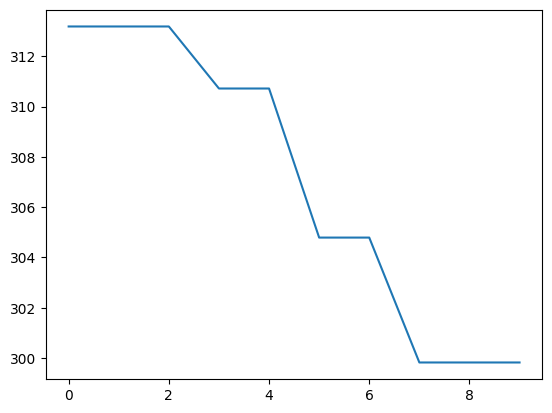

In [28]:
plt.plot(scene2.algo.population_history_fitness)

In [29]:
scene2.algo.population_history_fitness

[313.1895005077713,
 313.1895005077713,
 313.1895005077713,
 310.72206298134375,
 310.72206298134375,
 304.792068554615,
 304.792068554615,
 299.8238155412313,
 299.8238155412313,
 299.8238155412313]

In [30]:
scene2.algo.population_fitness

[368.0894409517249,
 310.0544885196208,
 335.58233070419465,
 318.12623932064434,
 315.1496671651793,
 327.73977093838477,
 303.9627587413872,
 299.8238155412313,
 338.8039608779234,
 307.2186758704006,
 334.4424525799777,
 341.2838545218737,
 311.22616075589934,
 365.28983899142963,
 340.2224448087586,
 335.975775038453,
 335.6610702031585,
 340.6542552642148,
 324.3669825076602,
 359.7630513083657]

In [31]:
scene2.current_best_fitness

301.2754721811294

# Method 3 - Forecast + Real Data

In [32]:
# Data parsing
method_obj_3 = build_data.Data(_file_path='data/EC_V4_new_UC1.xlsx', ec_id=1) 

In [33]:
method_obj_3.data.storage.keys()

dict_keys(['p_charge_limit', 'p_discharge_limit', 'charge_price', 'discharge_price', 'internal_bus_location', 'battery_type', 'owner', 'manager', 'type_contract', 'energy_capacity', 'energy_min_percentage', 'charge_efficiency', 'discharge_efficiency', 'initial_state', 'p_charge_max', 'p_discharge_max'])

## OBS: Preciso validar isso aqui, se o método 3 está igual ao original

In [34]:
all_data = []
all_models = []
results_dict = {}


integral_of_error_gen = np.zeros((5, 1))
integral_of_error_load = np.zeros((5, 1))

# True - Forecast - Based on Deterministic PYECOM Model (pyecomWforecats.ipynb):
forecast_error_load_at_time = method_obj_2.data.load['p_forecast'][:, :] - method_obj_1.get_data().load['p_forecast'][:, :] 
forecast_error_gen_at_time = method_obj_2.data.generator['p_forecast'][:, :] - method_obj_1.get_data().generator['p_forecast'][:, :]

for i in range(1, 24*60//_time_step+1):
    
    print(i)
    #  Result extraction - Saving the results on CSVs:
    results_folder = f'./results/UC1/method3/{i}_step'
    method3_folder = f"./input_data/UC1/method3/{i}_step"

    # Define generators
    gens3 = Generator(name='gens3',
                    value=np.zeros(method_obj_3.data.generator['p_forecast'].shape),
                    lower_bound=np.zeros(method_obj_3.data.generator['p_forecast'].shape),
                    upper_bound=method_obj_3.data.generator['p_forecast'],
                    cost=method_obj_3.data.generator['cost_parameter_b'],
                    cost_nde=method_obj_3.data.generator['cost_nde'],
                    is_renewable=method_obj_3.data.generator['type_generator'])

    method_obj_3.get_data_from_db(specific_date=_specific_date, table="generators_forecast", 
                                  experiment_id = 17, start=i, end = 24*60//_time_step, 
                                  time_step=_time_step)

    method_obj_3.get_data_from_db(specific_date=_specific_date, table="generators", start=0, end = i, 
                                  time_step=_time_step, folder=method3_folder, save=True)
    
    # Define loads
    loads3 = Load(name='loads3',
                value=method_obj_3.data.load['p_forecast'],
                lower_bound=np.zeros(method_obj_3.data.load['p_forecast'].shape),
                upper_bound=method_obj_3.data.load['p_forecast'],
                cost=np.ones(method_obj_3.data.load['p_forecast'].shape),
                cost_cut=method_obj_3.data.load['cost_cut'],
                cost_reduce=method_obj_3.data.load['cost_reduce'],
                cost_ens=method_obj_3.data.load['cost_ens'])


    method_obj_3.get_data_from_db(specific_date=_specific_date, table="loads_forecast", experiment_id = 23, 
                                  start=i, end = 24*60//_time_step, time_step=_time_step)

    method_obj_3.get_data_from_db(specific_date=_specific_date, table="loads",start=0, end = i, 
                                  time_step=_time_step, folder=method3_folder, save=True)

    # Define storage
    stor3 = Storage(name='stor3',
                value=np.zeros(method_obj_3.data.storage['p_charge_limit'].shape),
                lower_bound=np.zeros(method_obj_3.data.storage['p_charge_limit'].shape),
                upper_bound=(method_obj_3.data.storage['energy_capacity'] *
                                np.ones(method_obj_3.data.storage['p_charge_limit'].shape).transpose()).transpose(),
                cost=np.ones(method_obj_3.data.storage['p_charge_limit'].shape),
                cost_discharge=method_obj_3.data.storage['discharge_price'],
                cost_charge=method_obj_3.data.storage['charge_price'],
                capacity_max=method_obj_3.data.storage['energy_capacity'],
                capacity_min=method_obj_3.data.storage['energy_min_percentage'],
                initial_charge=method_obj_3.data.storage['initial_state'],
                discharge_efficiency=method_obj_3.data.storage['discharge_efficiency'],
                discharge_max=method_obj_3.data.storage['p_discharge_limit'],
                charge_efficiency=method_obj_3.data.storage['charge_efficiency'],
                charge_max=method_obj_3.data.storage['p_charge_limit'],
                #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
                #@TODO Coloquei array tamanho 4 no capital cost pois há 4 css
                capital_cost=np.array([0.05250, 0.10500, 0.01575, 0.01575]))
    stor3.to_json(filename=f"stor_0-{i}",path=method3_folder)

    # Define vehicle to grid
    v2g3 = Vehicle(name='evs3',
                value=np.zeros(method_obj_3.data.vehicle['schedule_charge'].shape),
                lower_bound=(method_obj_3.data.vehicle['e_capacity_max'] * method_obj_3.data.vehicle['min_technical_soc'] *
                            np.ones(method_obj_3.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
                upper_bound=(method_obj_3.data.vehicle['e_capacity_max'] * np.ones(method_obj_3.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
                cost=np.ones(method_obj_3.data.vehicle['schedule_charge'].shape),
                cost_discharge=method_obj_3.data.vehicle['discharge_price'][:, 0],
                cost_charge=method_obj_3.data.vehicle['charge_price'][:, 0],
                capacity_max=method_obj_3.data.vehicle['e_capacity_max'],
                initial_charge=np.ones(method_obj_3.data.vehicle['schedule_charge'].shape) * 0.8,
                min_charge=method_obj_3.data.vehicle['min_technical_soc'],
                discharge_efficiency=method_obj_3.data.vehicle['discharge_efficiency'],
                charge_efficiency=method_obj_3.data.vehicle['charge_efficiency'],
                #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
                #@TODO Coloquei array tamanho 7 no capital cost pois há 7 carros
                capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063, 0.063, 0.063]), 
                schedule_discharge=method_obj_3.data.vehicle['schedule_discharge'],
                schedule_charge=method_obj_3.data.vehicle['schedule_charge'])
    v2g3.to_json(filename=f"v2g_0-{i}",path=method3_folder)

    # Define imports and exports
    pimp3 = BinaryResource(name='pImp3',
                        value=np.zeros(method_obj_3.data.peers['import_contracted_p_max'][0, :].shape),
                        lower_bound=np.zeros(method_obj_3.data.peers['import_contracted_p_max'][0, :].shape),
                        upper_bound=method_obj_3.data.peers['import_contracted_p_max'][0, :],
                        cost=method_obj_3.data.peers['buy_price'][0, :],
                        is_active=np.zeros(method_obj_3.data.peers['import_contracted_p_max'][0, :].shape))
    pimp3.to_json(filename=f"pimp_0-{i}",path=method3_folder)

    pexp3 = BinaryResource(name='pExp3',
                        value=np.zeros(method_obj_3.data.peers['export_contracted_p_max'][0, :].shape),
                        lower_bound=np.zeros(method_obj_3.data.peers['export_contracted_p_max'][0, :].shape),
                        upper_bound=method_obj_3.data.peers['export_contracted_p_max'][0, :],
                        cost=method_obj_3.data.peers['sell_price'][0, :],
                        is_active=np.zeros(method_obj_3.data.peers['export_contracted_p_max'][0, :].shape))
    pexp3.to_json(filename=f"pexp_0-{i}",path=method3_folder)

    # Establish the components
    ec_components = {'gen': gens3,
                    'loads': loads3,
                    'stor': stor3,
                    'evs': v2g3,
                    'pimp': pimp3,
                    'pexp': pexp3}

    ec_components
    
    # Create the scene
    scene3 = HMProblemScene(name='EC3', data=ec_components, hm_parser=method_obj_3.data, pop_size=20,
                        n_iter=10, iter_tolerance=1000)
    scene3.initialize()
    scene3.run()

    # Store results in a dictionary

    results_dict = store_results(i, results_dict, 
                    scene3.current_best['pImp'], scene3.current_best['pExp'], scene3.current_best['genActPower'], 
                    scene3.current_best['genExcActPower'], scene3.current_best['genXo'], scene3.current_best['loadRedActPower'], 
                    scene3.current_best['loadCutActPower'], scene3.current_best['loadENS'], scene3.current_best['loadXo'], 
                    scene3.current_best['storEnerState'], scene3.current_best['storDchActPower'], scene3.current_best['storChActPower'], 
                    scene3.current_best['storDchXo'], scene3.current_best['storChXo'], scene3.current_best['v2gChActPower'], 
                    scene3.current_best['v2gDchActPower'], scene3.current_best['v2gEnerState'],
                    scene3.current_best['v2gDchXo'], 
                    scene3.current_best['v2gChXo']
                    )
    scene3.export_profile_to_excel(scene2.current_best['genActPower'], scene2.current_best['storDchActPower'],
                              scene2.current_best['v2gDchActPower'], scene2.current_best['loadRedActPower'],
                              scene2.current_best['loadCutActPower'], scene2.current_best['loadENS'],
                              scene2.current_best['pImp'], scene2.current_best['genExcActPower'],
                              scene2.current_best['storChActPower'], scene2.current_best['v2gChActPower'],
                              loads2.value,
                              name="profile_data_2.xlsx", path=results_folder
                              )
    

1


100%|██████████| 10/10 [00:00<00:00, 19.09it/s]


2


100%|██████████| 10/10 [00:00<00:00, 17.99it/s]


3


100%|██████████| 10/10 [00:00<00:00, 15.76it/s]


4


100%|██████████| 10/10 [00:00<00:00, 13.68it/s]


5


100%|██████████| 10/10 [00:00<00:00, 17.79it/s]


6


100%|██████████| 10/10 [00:00<00:00, 20.32it/s]


7


100%|██████████| 10/10 [00:00<00:00, 18.66it/s]


8


100%|██████████| 10/10 [00:00<00:00, 16.47it/s]


9


100%|██████████| 10/10 [00:00<00:00, 18.49it/s]


10


100%|██████████| 10/10 [00:00<00:00, 20.31it/s]


11


100%|██████████| 10/10 [00:00<00:00, 18.14it/s]


12


100%|██████████| 10/10 [00:00<00:00, 19.56it/s]


13


100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


14


100%|██████████| 10/10 [00:00<00:00, 17.16it/s]


15


100%|██████████| 10/10 [00:00<00:00, 15.68it/s]


16


100%|██████████| 10/10 [00:00<00:00, 15.74it/s]


17


100%|██████████| 10/10 [00:00<00:00, 15.74it/s]


18


100%|██████████| 10/10 [00:00<00:00, 18.80it/s]


19


100%|██████████| 10/10 [00:00<00:00, 16.80it/s]


20


100%|██████████| 10/10 [00:00<00:00, 19.03it/s]


21


100%|██████████| 10/10 [00:00<00:00, 19.25it/s]


22


100%|██████████| 10/10 [00:00<00:00, 18.01it/s]


23


100%|██████████| 10/10 [00:00<00:00, 13.63it/s]


24


100%|██████████| 10/10 [00:00<00:00, 20.25it/s]


In [35]:
#Plot the operation of the community results

result_genActPower = np.array([results_dict[hour]['genActPowerInit'] for hour in sorted(results_dict.keys())])
result_storDchActPower = np.array([results_dict[hour]['storDischargeInit'] for hour in sorted(results_dict.keys())])
result_v2gDchActPower = np.array([results_dict[hour]['v2gDischargeInit'] for hour in sorted(results_dict.keys())])
result_loadRedActPower = np.array([results_dict[hour]['loadRedActPowerInit'] for hour in sorted(results_dict.keys())])
result_loadCutActPower = np.array([results_dict[hour]['loadCutActPowerInit'] for hour in sorted(results_dict.keys())])
result_loadENS = np.array([results_dict[hour]['loadENSInit'] for hour in sorted(results_dict.keys())])
result_pimp = np.array([results_dict[hour]['importsInit'] for hour in sorted(results_dict.keys())])
result_genExcActPower = np.array([results_dict[hour]['genExcPowerInit'] for hour in sorted(results_dict.keys())])
result_storChActPower = np.array([results_dict[hour]['storChargeInit'] for hour in sorted(results_dict.keys())])
result_v2gChActPower = np.array([results_dict[hour]['v2gChargeInit'] for hour in sorted(results_dict.keys())])



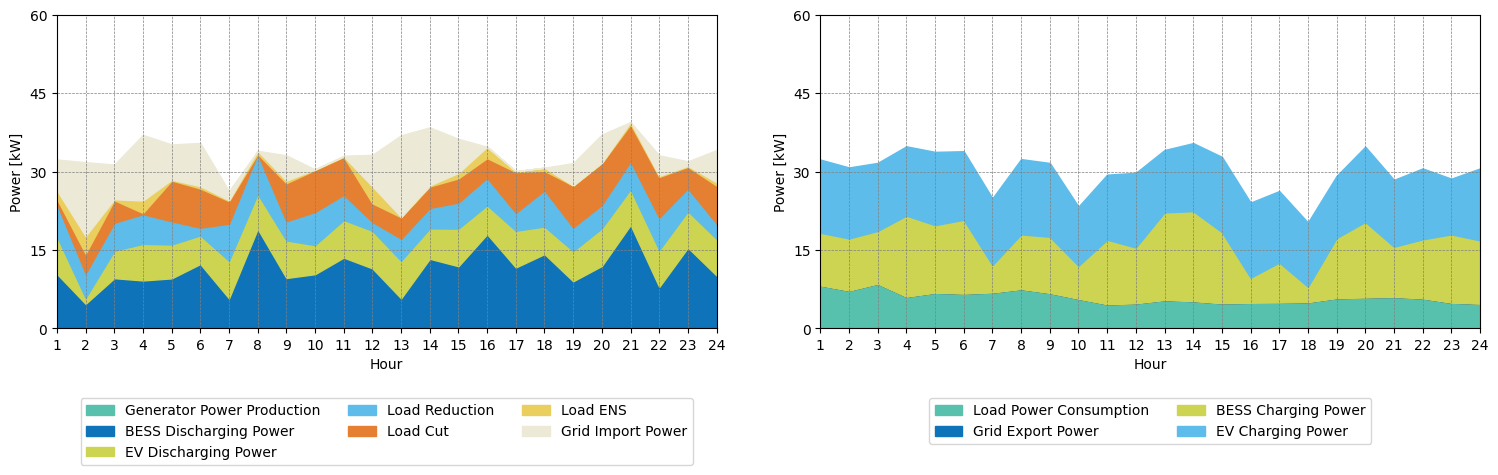

In [36]:
plot_mixed_results(result_genActPower,
    result_storDchActPower,
    result_v2gDchActPower,
    result_loadRedActPower,
    result_loadCutActPower,
    result_loadENS,
    result_pimp,
    method_obj_2, #The method 2 enters here, although this is method 3. Based on original PyECOM.
    _time_step,
    result_genExcActPower,
    result_storChActPower,
    result_v2gChActPower,
    save = True,
    path = 'plots/UC1/method_3',
    name =  f'profile_data_3.png',
    graph_max = 60,
    graph_step = 15)

In [37]:
# This function put on a excel all the data that was ploted on the previous part (plot_profile function)
export_mixed_results(
    result_genActPower,
    result_storDchActPower,
    result_v2gDchActPower,
    result_loadRedActPower,
    result_loadCutActPower,
    result_loadENS,
    result_pimp,
    method_obj_2, #The method 2 enters here, although this is method 3. Based on original PyECOM.
    _time_step,
    result_genExcActPower,
    result_storChActPower,
    result_v2gChActPower,
    path='./results/UC1/method_3',  
    name='step3_profile_data.xlsx'   
)